# $B_z$ extraction is simulation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
sys.path.append("../CommonUtils/")
import CommonUtils as cu

### Define constants and starting fit parameters

In [5]:
bin_w = 150*1e-3 # 150 ns 
min_x = 0 # us  #TODO 30 for data 
max_x = 500 # us 
p_min = 1800

print("Starting and end times [us]", min_x, max_x)
print("P cut [MeV]", p_min)

omega_a = 1.44 # MHz (magic)
gm2_f = 0.23 # MHz
gm2_asym = 0.45 
g2period = 2*np.pi / omega_a   # 4.36 us 

phase=6.240
print("Using derived phase of [rad]", phase)

ang_amp = 1.0
cos_amp = 1. / np.sqrt(2)
sin_amp = np.sqrt(1 - np.power(cos_amp, 2))
p0_ver=(ang_amp, cos_amp, omega_a, phase, sin_amp)

Starting and end times [us] 0 500
P cut [MeV] 1800
Using derived phase of [rad] 6.24


### Define fit functions

In [6]:
def f_vertical(t, *pars):
    N=pars[0]
    A_w=pars[1]
    omega=pars[2]
    phi=pars[3]
    A_edm=pars[4]
    return N*( A_w*np.cos(omega*t+phi) + A_edm*np.sin(omega*t+phi))


### Load HDF5 data and apply time and momentum cuts

In [7]:
data = pd.read_hdf("../DATA/HDF/Sim/VLEDM.h5", columns=("trackT0", "station", "trackMomentum", "trackMomentumY") )
mom_cut = (data['trackMomentum'] > p_min) # MeV  
time_cut = (data['trackT0'] > min_x) # MeV  
data=data[mom_cut & time_cut]

#define station cuts to loop over
# s12_cut = (data['station'] == stations[0])
# s18_cut = (data['station'] == stations[1])
# station_cut = (s12_cut, s18_cut)

### Resolve variables

In [8]:
p=data['trackMomentum']
py=data['trackMomentumY']
t=data['trackT0']
mod_times = cu.get_g2_mod_time(t) # Module the g-2 oscillation time 
theta_y = np.arctan2(py, p)
data['mod_times']=mod_times
data['theta_y']=theta_y
data

,trackT0,station,trackMomentum,trackMomentumY,mod_times,theta_y
2,80.277852,18,2544.615967,-59.835049,1.738035,-0.023510
3,42.755086,0,2182.920654,15.766864,3.485178,0.007223
6,10.879105,12,2120.369385,-8.798045,2.152459,-0.004149
18,11.418941,0,2252.512695,1.755878,2.692295,0.000780
20,204.562281,18,2131.132812,-22.711870,3.849417,-0.010657
...,...,...,...,...,...,...
5483776,70.492133,18,2016.368164,17.139523,0.678963,0.008500
5483788,33.120555,12,2171.714844,12.780183,2.577293,0.005885
5483789,82.543117,12,1940.134521,43.934719,4.003301,0.022641
5483793,21.286004,18,1840.056641,-38.210846,3.832711,-0.020763


### Digitise data

In [9]:
bin_c, freq = cu.get_freq_bin_c_from_data(mod_times, 0.01, (0, g2period) )
y_err = np.sqrt(freq)

### Plot counts vs. mod time

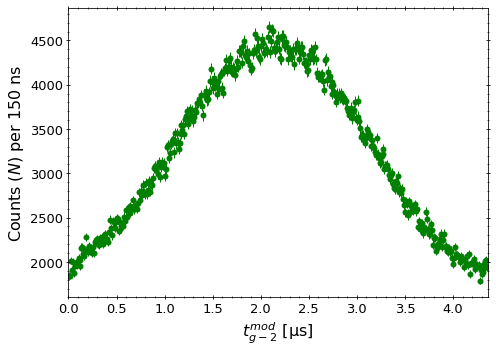

In [10]:
font_size=16
_, ax = cu.plot(bin_c, freq, scatter=True, lw=0, figsize=(7,5))
ax.errorbar(bin_c, freq, yerr=y_err*1, lw=0, c="g", elinewidth=1)
ax.set_xlim(0, g2period)
ax.set_xlabel(r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]", fontsize=font_size)
ax.set_ylabel(ylabel=r"Counts ($N$) per "+str(int(bin_w*1e3))+" ns", fontsize=font_size)
plt.tight_layout() 

### Profile the $\langle\theta_y\rangle$

In [ ]:
df_binned =cu.Profile(mod_times, theta_y, ax, nbins=15, xmin=np.min(x),xmax=np.max(x), mean=True)

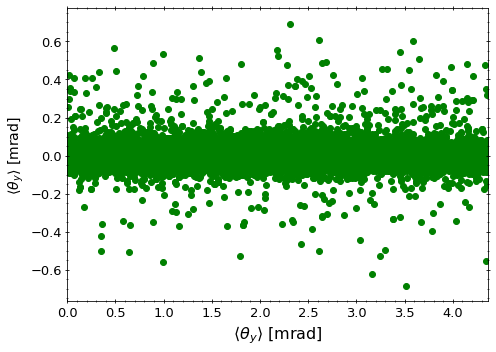

In [12]:
_, ax = cu.plot(, , scatter=True, lw=1, figsize=(7,5))
# ax.errorbar(bin_c, freq, yerr=y_err*1, lw=0, c="g", elinewidth=1)
ax.set_xlim(0, g2period)
ax.set_xlabel(r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]", fontsize=font_size)
ax.set_ylabel(r"$\langle\theta_y\rangle$ [mrad]", fontsize=font_size)
plt.tight_layout() 